In [9]:
import tensorflow as tf

import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers
import numpy as np
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [10]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [5]:
data = tf.data.TFRecordDataset('../../data/external/EuroSAT/eurosat/rgb/2.0.0/eurosat-train.tfrecord-00000-of-00001')

labels = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

SeaLake
(224, 224, 3)


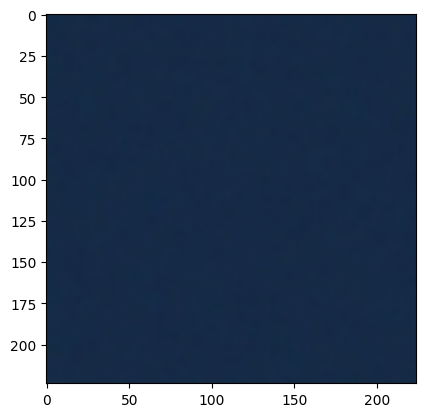

PermanentCrop
(224, 224, 3)


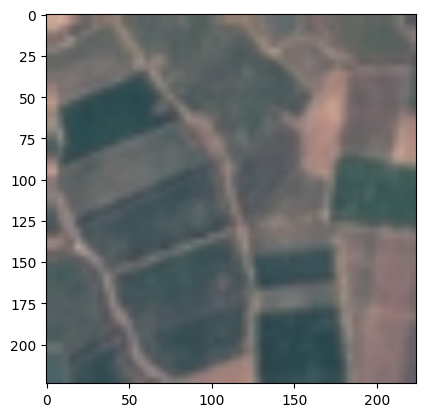

SeaLake
(224, 224, 3)


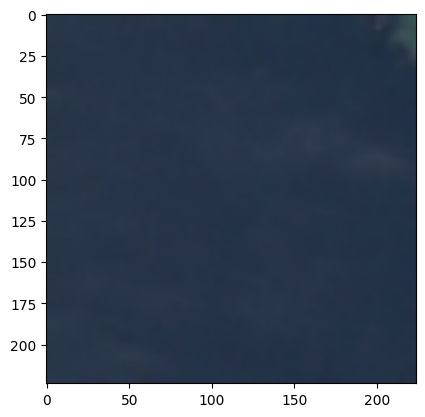

Industrial
(224, 224, 3)


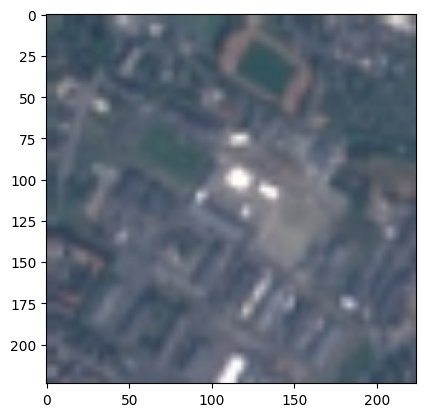

Pasture
(224, 224, 3)


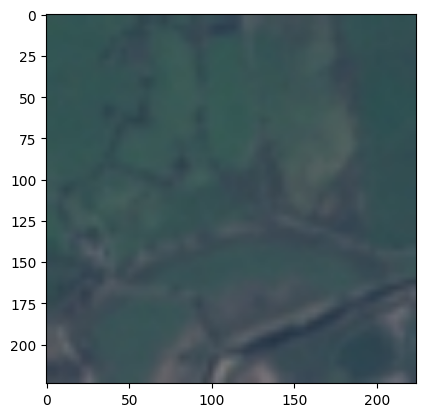

In [7]:
# parse single image from tfrecord
def parse_image(example_proto):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    parsed_features = tf.io.parse_single_example(example_proto, features)
    image = tf.io.decode_jpeg(parsed_features['image'])

    label = tf.cast(parsed_features['label'], tf.int32)
    return image, label

def resize_image(image, label):
    image = tf.image.resize(image, [224, 224])
    return image, label

def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image, label

def split_into_batches(dataset, batch_size):
    return dataset.cache().shuffle(27000).batch(batch_size)

def split_into_train_test_validation(dataset, batch_size):
    train_size = int(0.5 * 27000)
    validation_set = int(0.3 * 27000)
    test_size = int(0.2 * 27000)
    train_dataset = dataset.take(train_size).cache().shuffle(train_size)
    validation_dataset = dataset.skip(train_size).take(validation_set).cache().shuffle(validation_set)
    test_dataset = dataset.skip(train_size).skip(validation_set).take(test_size).cache().shuffle(test_size)
    return train_dataset, validation_dataset, test_dataset


def sample_images(dataset, batch_size, num_batches=500):
    return dataset.take(num_batches*batch_size).cache().batch(batch_size)

# parse first image from data
parsed_image_dataset = data.map(parse_image)
parsed_image_dataset = parsed_image_dataset.map(resize_image)

for image, label in parsed_image_dataset.take(5):
  image_raw = image.numpy()
  print(labels[label.numpy()])
  print(image_raw.shape)
  plt.imshow(image_raw.astype('uint8'))
  plt.show()
  plt.close()
  
parsed_image_dataset = parsed_image_dataset.map(normalize)
# split into train and test
train_dataset, validation_dataset, test_dataset = split_into_train_test_validation(parsed_image_dataset, 32)
train_dataset = sample_images(train_dataset, 50, num_batches=1000)
validation_dataset = sample_images(validation_dataset, 50)
test_dataset = sample_images(test_dataset, 50)

In [11]:
image_batch, label_batch = next(iter(train_dataset.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

2022-12-29 08:52:02.204886: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2/2 [==============================] - 1s 164ms/step


array(['velvet', 'velvet', 'velvet', 'velvet', 'cleaver', 'abaya',
       'velvet', 'velvet', 'theater curtain', 'velvet', 'velvet',
       'velvet', 'tile roof', 'revolver', 'velvet', 'neck brace',
       'wallet', 'cougar', 'velvet', 'platypus', 'nematode', 'velvet',
       'velvet', 'nematode', 'electric ray', 'worm fence', 'nematode',
       'scabbard', 'velvet', 'velvet', 'prayer rug', 'velvet', 'velvet',
       'velvet', 'packet', 'velvet', 'fox squirrel', 'velvet', 'velvet',
       'theater curtain', 'velvet', 'velvet', 'velvet', 'breastplate',
       'velvet', 'platypus', 'velvet', 'velvet', 'rock python', 'velvet'],
      dtype='<U30')

In [14]:
URL = "https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/5"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [15]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

feature_extractor.trainable = False

model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(10)
])

model.summary()

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset)

(50, 2048)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 2048)              58331648  
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 58,352,138
Trainable params: 20,490
Non-trainable params: 58,331,648
_________________________________________________________________
Epoch 1/6
270/270 [==============================] - 1812s 7s/step - loss: 2.3213 - accuracy: 0.4553 - val_loss: 2.1275 - val_accuracy: 0.4688
Epoch 2/6
270/270 [==============================] - ETA: 0s - loss: 2.1533 - accuracy: 0.4541

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()